In [1]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
plt.rcParams['figure.figsize'] = [15, 7.5]

(128, 128)
(4, 128, 128)
min: 0.0 , max: 0.996078431372549


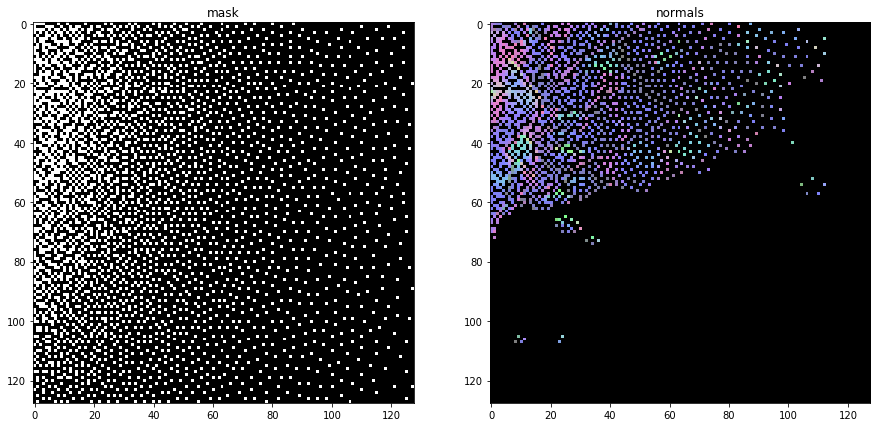

In [13]:
import imageio
inputMask = imageio.imread("inpainting-mask.png")[:,:,0]/255.0
print(inputMask.shape)
inputNormals = imageio.imread("inpainting-normals.png").transpose((2,0,1))/255.0
print(inputNormals.shape)
print("min:", np.min(inputNormals[0:3,:,:]), ", max:", np.max(inputNormals[0:3,:,:]))

def show_image(axis, image, title=None):
    image = np.clip(image, 0, 1)
    normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
    if len(image.shape)==3: #rgb(a)
        if image.shape[0]==3 or image.shape[0]==4:
            axis.imshow(image[0:3,:,:].transpose(1,2,0)) #rgb(a)
        elif image.shape[0]==1:
            axis.imshow(image[0], norm=normalize, cmap='gray') #gray (unsqueezed)
    else:
        axis.imshow(image, norm=normalize, cmap='gray')
    if title is not None:
        axis.set_title(title)

fig, ax = plt.subplots(nrows=1, ncols=2)
show_image(ax[0], inputMask, "mask")
show_image(ax[1], inputNormals, "normals")
plt.rcParams['figure.figsize'] = [15, 7.5]

In [3]:
# first version: assumes power-of-two size
def inpaint(mask, data, callback, minSize=1, _level=0):
    """
    mask: (H, W)
    data: (C, H, W)
    callback: function with callback(level, maskPre, dataPre, maskPost, dataPost)
    """
    H, W = mask.shape
    C, _, _ = data.shape
    if H<=minSize or W<=minSize:
        # end of recursion
        callback(_level, mask, data, mask, data)
        return mask, data
    if np.all(mask>0.5):
        # all pixels filled -> early termination
        callback(_level, mask, data, mask, data)
        return mask, data
    # downsample
    maskLow = np.zeros((H//2, W//2), dtype=mask.dtype)
    dataLow = np.zeros((C, H//2, W//2), dtype=data.dtype)
    for i in range(H//2):
        for j in range(W//2):
            N = 0
            d = np.zeros(C, dtype=data.dtype)
            for (ii,jj) in [(i*2,j*2), (i*2+1,j*2), (i*2,j*2+1), (i*2+1,j*2+1)]:
                if mask[ii,jj]>0.5:
                    N += 1
                    d += data[:,ii,jj]
            if N>0:
                maskLow[i,j] = 1
                dataLow[:,i,j] = d / N
    # recursion
    maskLow, dataLow = inpaint(maskLow, dataLow, callback, minSize, _level+1)
    # upsample
    maskHigh = np.zeros((H, W), dtype=mask.dtype)
    dataHigh = np.zeros((C, H, W), dtype=data.dtype)
    for i in range(H):
        for j in range(W):
            if mask[i,j]>0.5:
                # copy unchanged
                maskHigh[i,j] = 1
                dataHigh[:,i,j] = data[:,i,j]
            else:
                # interpolate from low resolution (bilinear)
                # get neighbors with weight
                nx = []
                nx += [(i//2, j//2, 0.75*0.75)]
                io = -1 if i%2==0 else +1
                jo = -1 if j%2==0 else +1
                nx += [(i//2+io, j//2, 0.25*0.75), (i//2, j//2+jo, 0.25*0.75)]
                nx += [(i//2+io, j//2+jo, 0.25*0.25)]
                # accumulate
                N = 0
                d = np.zeros(C, dtype=data.dtype)
                for (ii,jj,w) in nx:
                    if ii>=0 and jj>=0 and ii<H//2 and jj<W//2 and maskLow[ii,jj]>0.5:
                        N += w
                        d += w * dataLow[:,ii,jj]
                if N>0:
                    maskHigh[i,j] = 1
                    dataHigh[:,i,j] = d / N
    # notify callback
    callback(_level, mask, data, maskHigh, dataHigh)
    return maskHigh, dataHigh

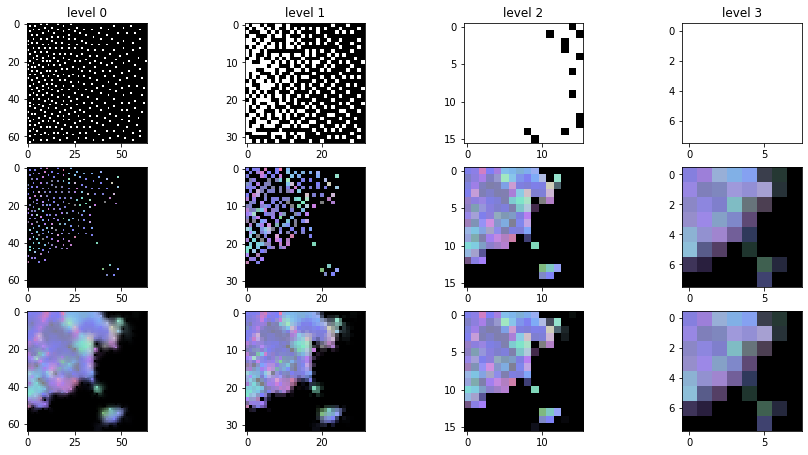

In [21]:
images = []
def callback(level, maskPre, dataPre, maskPost, dataPost):
    images.append((level, maskPre, dataPre, maskPost, dataPost))

inpaint(inputMask[:64,64:], inputNormals[...,:64,64:], callback)
numLevels = len(images)

fig, ax = plt.subplots(nrows=3, ncols=numLevels)
for (level, maskPre, dataPre, maskPost, dataPost) in images:
    show_image(ax[0,level], maskPre, "level %d"%level)
    show_image(ax[1,level], dataPre)
    #show_image(ax[2,level], maskPost)
    show_image(ax[2,level], dataPost)
    
    # Test: save
    cmap = plt.cm.gray
    norm = plt.Normalize(vmin=0, vmax=1)
    plt.imsave('inpainting-level%d-mask.png'%level, cmap(norm(maskPre)))
    plt.imsave('inpainting-level%d-pre.png'%level, dataPre.transpose(1,2,0))
    plt.imsave('inpainting-level%d-post.png'%level, dataPost.transpose(1,2,0))

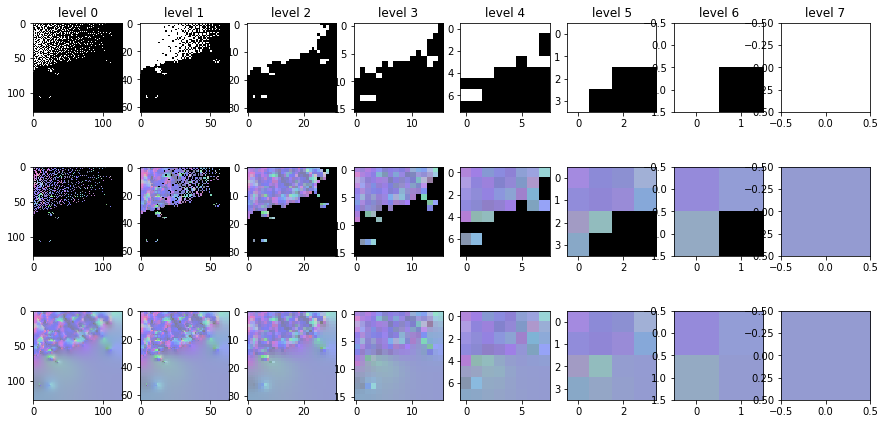

In [22]:
# now impaint only valid areas
inputMask2 = inputNormals[3,:,:]

images = []
inpaint(inputMask2, inputNormals, callback)
numLevels = len(images)

fig, ax = plt.subplots(nrows=3, ncols=numLevels)
for (level, maskPre, dataPre, maskPost, dataPost) in images:
    show_image(ax[0,level], maskPre, "level %d"%level)
    show_image(ax[1,level], dataPre)
    #show_image(ax[2,level], maskPost)
    show_image(ax[2,level], dataPost)

In [23]:
# now extend the inpainting algorithm to non power-of-two sizes
def inpaint2(mask, data, callback, minSize=1, _level=0):
    """
    mask: (H, W)
    data: (C, H, W)
    callback: function with callback(level, maskPre, dataPre, maskPost, dataPost)
    """
    
    H, W = mask.shape
    oH, oW = H//2, W//2
    C, _, _ = data.shape
    if H<=minSize or W<=minSize:
        # end of recursion
        callback(_level, mask, data, mask, data)
        return mask, data
    if np.all(mask>0.5):
        # all pixels filled -> early termination
        callback(_level, mask, data, mask, data)
        return mask, data
    
    # helper for loop index calculations
    def start_index(a, b, c):
        return int(np.floor(a*c/b))
    def end_index(a, b, c):
        return int(np.ceil((a+1)*c/b))
    
    # downsample
    maskLow = np.zeros((oH, oW), dtype=mask.dtype)
    dataLow = np.zeros((C, oH, oW), dtype=data.dtype)
    for i in range(oH):
        for j in range(oW):
            N = 0
            d = np.zeros(C, dtype=data.dtype)
            for ii in range(start_index(i, oH, H), end_index(i, oH, H)):
                for jj in range(start_index(j, oW, W), end_index(j, oW, W)):
                    if mask[ii,jj]>0.5:
                        N += 1
                        d += data[:,ii,jj]
            if N>0:
                maskLow[i,j] = 1
                dataLow[:,i,j] = d / N
    # recursion
    maskLow, dataLow = inpaint2(maskLow, dataLow, callback, minSize, _level+1)
    # upsample
    maskHigh = np.zeros((H, W), dtype=mask.dtype)
    dataHigh = np.zeros((C, H, W), dtype=data.dtype)
    for i in range(H):
        for j in range(W):
            if mask[i,j]>0.5:
                # copy unchanged
                maskHigh[i,j] = 1
                dataHigh[:,i,j] = data[:,i,j]
            else:
                # interpolate from low resolution (bilinear)
                # get neighbors with weight
                nx = []
                nx += [(i//2, j//2, 0.75*0.75)]
                io = -1 if i%2==0 else +1
                jo = -1 if j%2==0 else +1
                nx += [(i//2+io, j//2, 0.25*0.75), (i//2, j//2+jo, 0.25*0.75)]
                nx += [(i//2+io, j//2+jo, 0.25*0.25)]
                # accumulate
                N = 0
                d = np.zeros(C, dtype=data.dtype)
                for (ii,jj,w) in nx:
                    if ii>=0 and jj>=0 and ii<oH and jj<oW and maskLow[ii,jj]>0.5:
                        N += w
                        d += w * dataLow[:,ii,jj]
                if N>0:
                    maskHigh[i,j] = 1
                    dataHigh[:,i,j] = d / N
    # notify callback
    callback(_level, mask, data, maskHigh, dataHigh)
    return maskHigh, dataHigh

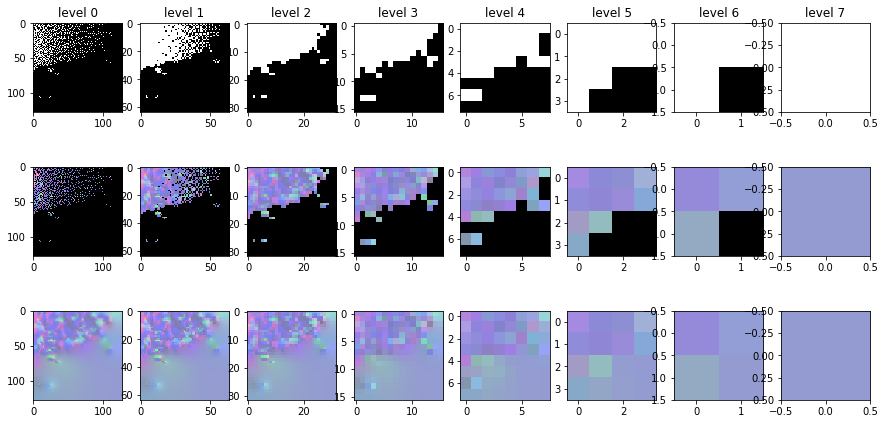

In [24]:
# test that it still works
inputMask2 = inputNormals[3,:,:]

images = []
inpaint2(inputMask2, inputNormals, callback)
numLevels = len(images)

fig, ax = plt.subplots(nrows=3, ncols=numLevels)
for (level, maskPre, dataPre, maskPost, dataPost) in images:
    show_image(ax[0,level], maskPre, "level %d"%level)
    show_image(ax[1,level], dataPre)
    #show_image(ax[2,level], maskPost)
    show_image(ax[2,level], dataPost)

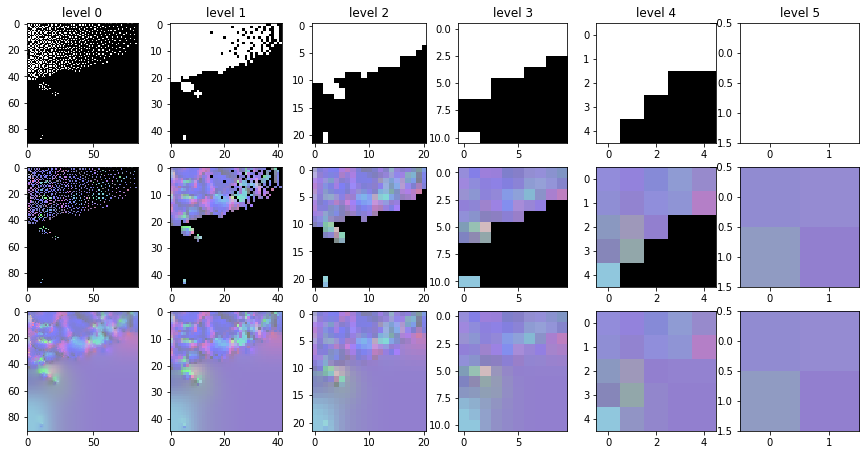

In [25]:
# test non-power of two sizes
startX, endX = 20, 111
startY, endY = 13, 97
inputMask3 = inputNormals[3,startX:endX,startY:endY]
inputNormals3 = inputNormals[:,startX:endX,startY:endY]

images = []
inpaint2(inputMask3, inputNormals3, callback)
numLevels = len(images)

fig, ax = plt.subplots(nrows=3, ncols=numLevels)
for (level, maskPre, dataPre, maskPost, dataPost) in images:
    show_image(ax[0,level], maskPre, "level %d"%level)
    show_image(ax[1,level], dataPre)
    #show_image(ax[2,level], maskPost)
    show_image(ax[2,level], dataPost)

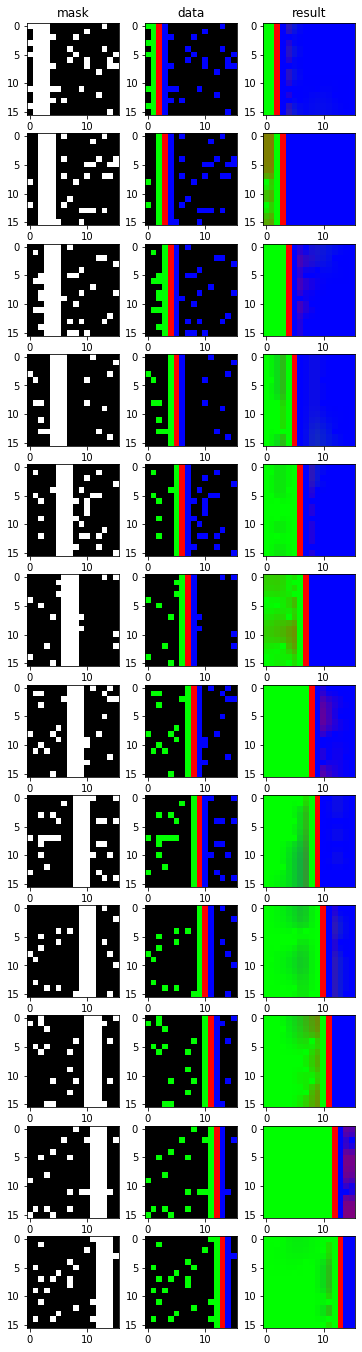

In [27]:
# test if information bleeds over corners

S = 16
fig, ax = plt.subplots(nrows=S-4, ncols=3, figsize=(6,2*(S-4)))
for sep in range(2,S-2):
    mask = (np.random.rand(S,S) > 0.9) * 1.0
    mask[:,sep-1:sep+2].fill(1)
    data = np.zeros((3,S,S), dtype=mask.dtype)
    data[0,:,sep].fill(1)
    data[1,:,:sep].fill(1)
    data[2,:,sep+1:].fill(1)
    data = data * mask[np.newaxis,:,:]
    
    images = []
    _, result = inpaint2(mask, data, callback)
    
    show_image(ax[sep-2,0], mask, "mask" if sep==2 else None)
    show_image(ax[sep-2,1], data, "data" if sep==2 else None)
    show_image(ax[sep-2,2], result, "result" if sep==2 else None)
    
    #save images
    if sep==6:
        cmap = plt.cm.gray
        plt.imsave('inpainting-error-mask.png', cmap(mask))
        plt.imsave('inpainting-error-data.png', data.transpose(1,2,0))
        plt.imsave('inpainting-error-result.png', result.transpose(1,2,0))

In [30]:
# now we extend it to fractional masks
def inpaintFractional(mask, data, callback, minSize=1, _level=0):
    """
    mask: (H, W)
    data: (C, H, W)
    callback: function with callback(level, maskPre, dataPre, maskPost, dataPost)
    """
    
    H, W = mask.shape
    oH, oW = H//2, W//2
    C, _, _ = data.shape
    if H<=minSize or W<=minSize:
        # end of recursion
        callback(_level, mask, data, mask, data)
        return mask, data
    
    # helper for loop index calculations
    def start_index(a, b, c):
        return int(np.floor(a*c/b))
    def end_index(a, b, c):
        return int(np.ceil((a+1)*c/b))
    
    # downsample
    maskLow = np.zeros((oH, oW), dtype=mask.dtype)
    dataLow = np.zeros((C, oH, oW), dtype=data.dtype)
    for i in range(oH):
        for j in range(oW):
            N = 0
            N2 = 0
            Count = 0
            d = np.zeros(C, dtype=data.dtype)
            for ii in range(start_index(i, oH, H), end_index(i, oH, H)):
                for jj in range(start_index(j, oW, W), end_index(j, oW, W)):
                    #N += mask[ii,jj]
                    N2 += mask[ii,jj]
                    N = max(N, mask[ii,jj])
                    d += mask[ii,jj] * data[:,ii,jj]
                    Count += 1
            if N>0:
                maskLow[i,j] = N
                #maskLow[i,j] = N2 / Count
                dataLow[:,i,j] = d / N2
    # recursion
    maskLow, dataLow = inpaintFractional(maskLow, dataLow, callback, minSize, _level+1)
    # upsample
    maskHigh = np.zeros((H, W), dtype=mask.dtype)
    dataHigh = np.zeros((C, H, W), dtype=data.dtype)
    for i in range(H):
        for j in range(W):
            # interpolate from low resolution (bilinear)
            # get neighbors with weight
            nx = []
            nx += [(i//2, j//2, 0.75*0.75)]
            io = -1 if i%2==0 else +1
            jo = -1 if j%2==0 else +1
            nx += [(i//2+io, j//2, 0.25*0.75), (i//2, j//2+jo, 0.25*0.75)]
            nx += [(i//2+io, j//2+jo, 0.25*0.25)]
            # accumulate
            N = 0
            d = np.zeros(C, dtype=data.dtype)
            WW = 0
            for (ii,jj,w) in nx:
                if ii>=0 and jj>=0 and ii<oH and jj<oW:
                    N += w * maskLow[ii,jj]
                    d += w * maskLow[ii,jj] * dataLow[:,ii,jj]
                    WW += w
            # blend with original data
            maskHigh[i,j] = mask[i,j]
            dataHigh[:,i,j] = mask[i,j] * data[:,i,j]
            if N>0:
                maskHigh[i,j] += (1-mask[i,j]) * N / WW
                dataHigh[:,i,j] += (1-mask[i,j]) * d / N
    # notify callback
    callback(_level, mask, data, maskHigh, dataHigh)
    return maskHigh, dataHigh

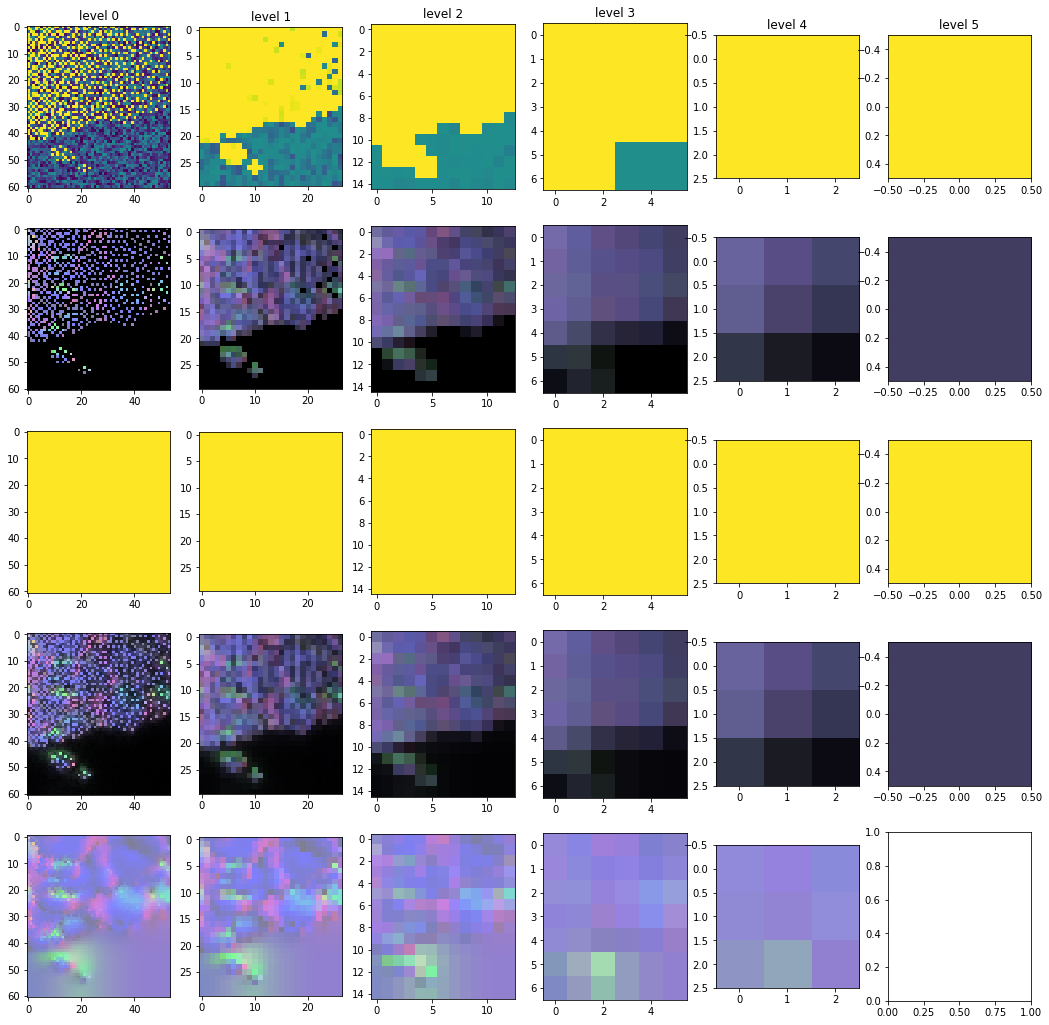

In [23]:
# test non-power of two sizes
startX, endX = 20, 81
startY, endY = 13, 67
inputMask4 = inputNormals[3,startX:endX,startY:endY]
inputNormals4 = inputNormals[:,startX:endX,startY:endY]
inputMask4 = np.clip(0.9 * inputMask4 + 0.5 * np.random.rand(*inputMask4.shape), 0, 1)

images = []
_, inputNormalsInpainted = inpaint2(inputMask4, inputNormals4, callback)

images = []
inpaintFractional(inputMask4, inputNormals4, callback)
numLevels = len(images)

fig, ax = plt.subplots(nrows=5, ncols=numLevels, figsize=(18,18))
for (level, maskPre, dataPre, maskPost, dataPost) in images:
    show_image(ax[0,level], maskPre, "level %d"%level)
    show_image(ax[1,level], dataPre)
    show_image(ax[2,level], maskPost)
    show_image(ax[3,level], dataPost)
    
images = []
inpaint2(inputMask4, inputNormals4, callback)
for (level, maskPre, dataPre, maskPost, dataPost) in images:
    show_image(ax[4,level], dataPost)

In [40]:
# load test data for adaptive bluring
downsample = 1/4
from skimage import transform
bonsaiData = transform.rescale(imageio.imread("BonsaiData.png")/255.0, downsample).transpose((2,0,1))
bonsaiMask1 = transform.rescale(imageio.imread("BonsaiMask1.png")/255.0, downsample)[:,:,0]
bonsaiMask2 = transform.rescale(imageio.imread("BonsaiMask2.png")/255.0, downsample)[:,:,0]

In [41]:
# test adaptive smoothing
minValue = 0.05
bonsaiMask1_scaled = (bonsaiMask1 / np.max(bonsaiMask1)) * (1-minValue) + minValue
bonsaiMask2_scaled = (bonsaiMask2 / np.max(bonsaiMask2)) * (1-minValue) + minValue

images = []
_, bonsaiSmooth1 = inpaintFractional(bonsaiMask1_scaled, bonsaiData, callback)
images = []
_, bonsaiSmooth2 = inpaintFractional(bonsaiMask2_scaled, bonsaiData, callback)

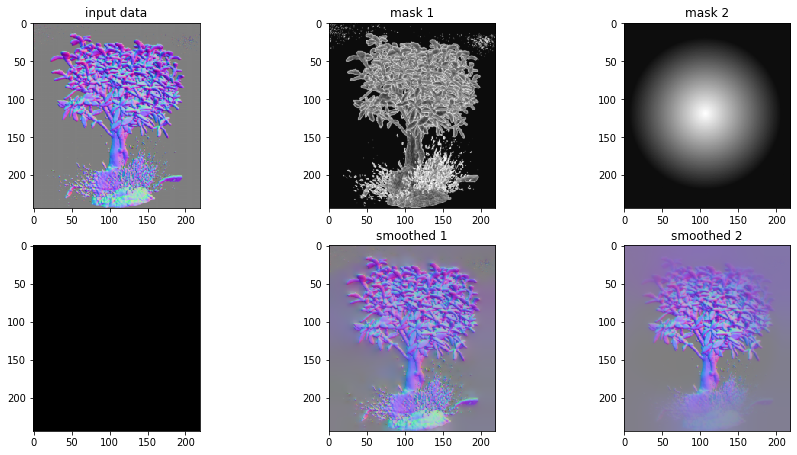

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=3)#, figsize=(18,12))
show_image(ax[0,0], bonsaiData, "input data")
show_image(ax[0,1], bonsaiMask1_scaled, "mask 1")
show_image(ax[0,2], bonsaiMask2_scaled, "mask 2")
show_image(ax[1,0], np.zeros(bonsaiData.shape, dtype=bonsaiData.dtype))
show_image(ax[1,1], bonsaiSmooth1, "smoothed 1")
show_image(ax[1,2], bonsaiSmooth2, "smoothed 2")

cmap = plt.cm.gray
plt.imsave('inpainting-bonsai-mask.png', cmap(bonsaiMask2_scaled))
plt.imsave('inpainting-bonsai-data.png', bonsaiData.transpose(1,2,0))
plt.imsave('inpainting-bonsai-result.png', bonsaiSmooth2.transpose(1,2,0))

In [25]:
# test adaptive smoothing on a real example
EjectaData = imageio.imread("TestSmoothingInput.png").transpose((2,0,1))/255.0
EjectaMask1 = imageio.imread("TestSmoothingHeatmap1.png")[:,:]/255.0

mask min: 0.050980392156862744 , max: 1.0


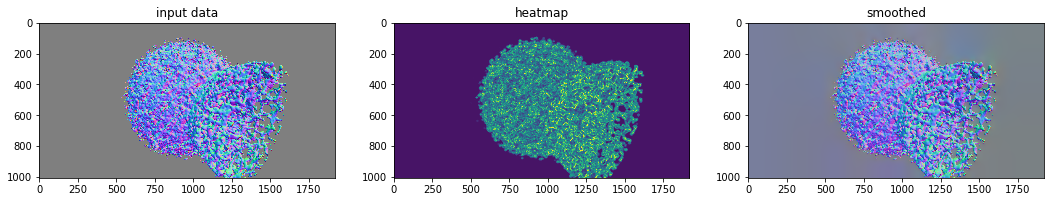

In [26]:
print("mask min:", np.min(EjectaMask1), ", max:", np.max(EjectaMask1))

images = []
_, EjectaSmooth1 = inpaintFractional(EjectaMask1, EjectaData, callback)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
show_image(ax[0], EjectaData, "input data")
show_image(ax[1], EjectaMask1, "heatmap")
show_image(ax[2], EjectaSmooth1, "smoothed")

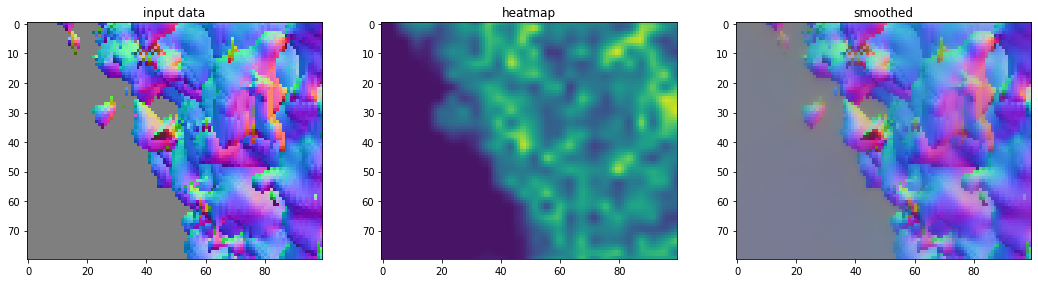

In [28]:
leftX = 550; rightX = 650;
lowerY = 600; upperY = 680;
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
show_image(ax[0], EjectaData[:, lowerY:upperY, leftX:rightX], "input data")
show_image(ax[1], EjectaMask1[lowerY:upperY, leftX:rightX], "heatmap")
show_image(ax[2], EjectaSmooth1[:, lowerY:upperY, leftX:rightX], "smoothed")

mask min: 0.054901960784313725 , max: 0.396078431372549


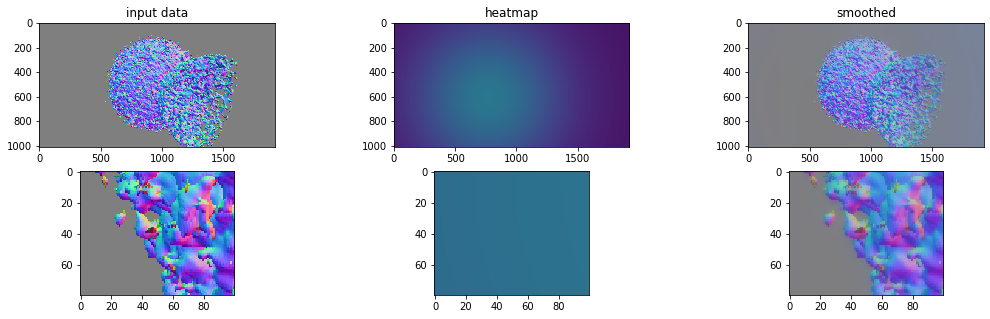

In [29]:
EjectaMask2 = imageio.imread("TestSmoothingHeatmap2.png")[:,:]/255.0
print("mask min:", np.min(EjectaMask2), ", max:", np.max(EjectaMask2))

images = []
_, EjectaSmooth2 = inpaintFractional(EjectaMask2, EjectaData, callback)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,5))
show_image(ax[0,0], EjectaData, "input data")
show_image(ax[0,1], EjectaMask2, "heatmap")
show_image(ax[0,2], EjectaSmooth2, "smoothed")
show_image(ax[1,0], EjectaData[:, lowerY:upperY, leftX:rightX])
show_image(ax[1,1], EjectaMask2[lowerY:upperY, leftX:rightX])
show_image(ax[1,2], EjectaSmooth2[:, lowerY:upperY, leftX:rightX])